# Torneo SNA 2025

* Nombre equipo:
  * 3DIC
* Participantes:
  * Paula Corral rebollar
  * Lucía Cuevas Serrano

# Instalar dependencias

In [85]:
!pip install torch_geometric

# Cargar el dataset

In [86]:
import json
import networkx as nx
import os
import os.path as osp
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.utils.convert import from_networkx
from zipfile import ZipFile

class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/WTBtQ3HH2GjpGAi/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        self.train_idx = torch.load(self.processed_paths[1], weights_only=False)
        self.test_idx = torch.load(self.processed_paths[2], weights_only=False)

    @property
    def raw_file_names(self):
        return ['nx_graphs.zip']

    @property
    def processed_file_names(self):
        return ['geometric_data_processed.pt', "train_idx.pt", "test_idx.pt"]

    @property
    def num_classes(self):
        return 1

    @property
    def num_features(self):
        return 9

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='nx_graphs.zip')

    def process(self):

        with ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)

        data_list = []
        train_idx = []
        test_idx = []
        for f in os.listdir(osp.join(self.raw_dir, "nx_graphs")):
            G = nx.read_gml(osp.join(self.raw_dir, "nx_graphs", f))
            data = from_networkx(G)
            data.x = data.x.float()

            data.nid = torch.tensor([G.graph["molecule_id"]], dtype=torch.long)
            data_list.append(data)

            if G.graph["set"] == "training":
                data.y = torch.tensor([G.graph["y"]], dtype=torch.float)
                train_idx.append(G.graph["molecule_id"])
            else:
                data.y = torch.tensor([torch.nan], dtype=torch.float)
                test_idx.append(G.graph["molecule_id"])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data_list.sort(key=lambda x: x.nid.item())

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(train_idx, self.processed_paths[1])
        torch.save(test_idx, self.processed_paths[2])

Number of molecules: 4200
Number of node attributes: 9
Example Graph: Data(x=[22, 9], edge_index=[2, 50], y=[1], molecule_id=[1], set='training', nid=[1])
Training set size: 3360
Test set size: 840
Trainning distribution: count    3360.000000
mean        2.200554
std         1.199276
min        -1.500000
25%         1.437500
50%         2.360000
75%         3.100000
max         4.500000
dtype: float64
Test distribution: Counter({'nan': 840})


Text(0.5, 1.0, 'Histogram of training labels')

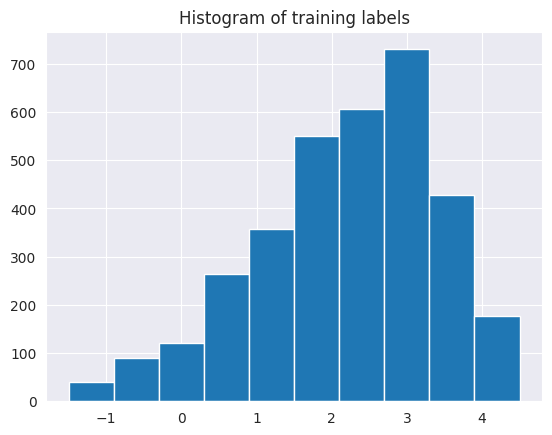

In [87]:
from collections import Counter
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

dataset = TournamentDataset(root='tournament')

print(f"Number of molecules: {len(dataset)}")
print(f"Number of node attributes: {dataset.num_features}")
print(f"Example Graph: {dataset[0]}")
print(f"Training set size: {len(dataset.train_idx)}")
print(f"Test set size: {len(dataset.test_idx)}")
print(f"Trainning distribution: {pd.Series([dataset[i].y.item() for i in dataset.train_idx]).describe()}")
print(f"Test distribution: {Counter([str(dataset[i].y.item()) for i in dataset.test_idx])}")

pd.Series([dataset[i].y.item() for i in dataset.train_idx]).hist()
plt.title("Histogram of training labels")

# Dividir datos

In [88]:
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# 1. DIVIDIMOS
# train_indices, val_indices = train_test_split(train_idx, test_size=0.15, random_state=42)
train_indices = train_idx

# 2. PREPARACIÓN DE DATOS DE ENTRENAMIENTO
y_train_vals = np.array([dataset[i].y.item() for i in train_indices])
train_data_original = [dataset[i] for i in train_indices]

# Definimos los bins (zonas) para discretizar
bins = np.arange(np.floor(y_train_vals.min()), np.ceil(y_train_vals.max()) + 1, 1)
y_binned = pd.cut(y_train_vals, bins=bins)

# Análisis de frecuencias
counts = y_binned.value_counts()
target_count = counts.max()

# 3. IMPLEMENTACIÓN DEL OVERSAMPLING (Solo para Training)
train_data_oversampled = []
indices_por_bin = {interval: [] for interval in counts.index}

for idx, interval in enumerate(y_binned):
    indices_por_bin[interval].append(idx)

for interval, idxs in indices_por_bin.items():
    if len(idxs) == 0: continue
    # Calculamos el multiplicador para balancear la zona
    num_copias = int(np.ceil(target_count / len(idxs)))
    for i in idxs:
        train_data_oversampled.extend([train_data_original[i]] * num_copias)

# 4. PREPARACIÓN DE DATOS DE VALIDACIÓN (Sin oversampling, Pág. 32)
#val_data = [dataset[i] for i in val_indices]

# 5. CREACIÓN DE DATALOADERS
# Batch size alto para entrenamiento (puedes ajustarlo según tu GPU)
train_loader = DataLoader(train_data_oversampled, batch_size=512, shuffle=True)
# Batch size para validación suele ser el total o uno grande para evaluar rápido
#val_loader = DataLoader(val_data, batch_size=512, shuffle=False)

print(f"--- Resumen de Datos ---")
print(f"Original Train: {len(train_indices)} -> Oversampled: {len(train_data_oversampled)}")
print(f"Validation (Real): {len(val_data)}")

pd.Series([d.y.item() for d in train_data_oversampled]).hist()
plt.title("Histogram of training labels")

--- Resumen de Datos ---
Original Train: 2856 -> Oversampled: 7475
Validation (Real): 429


In [ ]:
[d.y.item() for d in train_data_oversampled]

# Definir modelo

In [89]:
from torch.nn import Module
from torch_geometric.nn import GCN, MLP, global_add_pool

class GCNGraph(Module):

    def __init__(self, num_features, num_classes, hidden_channels=64, n_layers=3):
        super(GCNGraph, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gcn(x.float(), edge_index)
        x = global_add_pool(x, batch)
        x = self.cls(x)
        return x

In [90]:
from torch_geometric.nn import GCNConv, MLP
import torch.nn.functional as F

# Definimos el modelo con ConvolucionalGCN
class GCNConvol(Module):
    def __init__(self, node_features, num_classes, hidden_channels=64):
        super(GCNConvol, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_add_pool(x, batch)
        x = self.cls(x)
        return x


# Entrenar el modelo

In [91]:
def validate(model):
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())

    print(f"RMSE en validación: {root_mean_squared_error(y_true, y_pred)}")



In [92]:
import torch

def train(model):
  model.train()
  total_loss = 0

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()

    y_true = data.y.view(-1)
    y_pred = model(data).view(-1)

    loss = criterion(y_pred, y_true)

    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(train_loader)

device = "cuda" if torch.cuda.is_available() else "cpu"

# model_baseline = GCNGraph(dataset.num_features, 1)
# model_baseline = model.to(device)

model = GCNConvol(dataset.num_features, 1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.HuberLoss()

for epoch in range(501):
    train_loss = train(model)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}')
    #if epoch % 100 == 0:
        #validate(model)


Epoch: 0, Train Loss: 1.7377
Epoch: 10, Train Loss: 0.8255
Epoch: 20, Train Loss: 0.7085
Epoch: 30, Train Loss: 0.6030
Epoch: 40, Train Loss: 0.5365
Epoch: 50, Train Loss: 0.4997
Epoch: 60, Train Loss: 0.4903
Epoch: 70, Train Loss: 0.4463
Epoch: 80, Train Loss: 0.4252
Epoch: 90, Train Loss: 0.4152
Epoch: 100, Train Loss: 0.4081
Epoch: 110, Train Loss: 0.4096
Epoch: 120, Train Loss: 0.3941
Epoch: 130, Train Loss: 0.4040
Epoch: 140, Train Loss: 0.3904
Epoch: 150, Train Loss: 0.3927
Epoch: 160, Train Loss: 0.3853
Epoch: 170, Train Loss: 0.3596
Epoch: 180, Train Loss: 0.3657
Epoch: 190, Train Loss: 0.3675
Epoch: 200, Train Loss: 0.3564
Epoch: 210, Train Loss: 0.3408
Epoch: 220, Train Loss: 0.3506
Epoch: 230, Train Loss: 0.3361
Epoch: 240, Train Loss: 0.3327
Epoch: 250, Train Loss: 0.3264
Epoch: 260, Train Loss: 0.3205
Epoch: 270, Train Loss: 0.3095
Epoch: 280, Train Loss: 0.3191
Epoch: 290, Train Loss: 0.3115
Epoch: 300, Train Loss: 0.3130
Epoch: 310, Train Loss: 0.3222
Epoch: 320, Train L

# Validación

RMSE: 0.7509691325670942


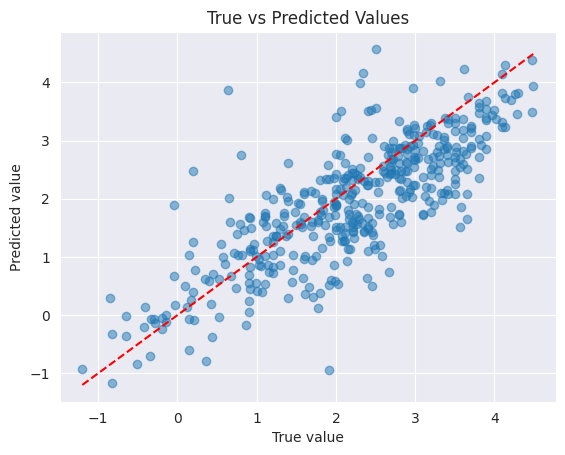

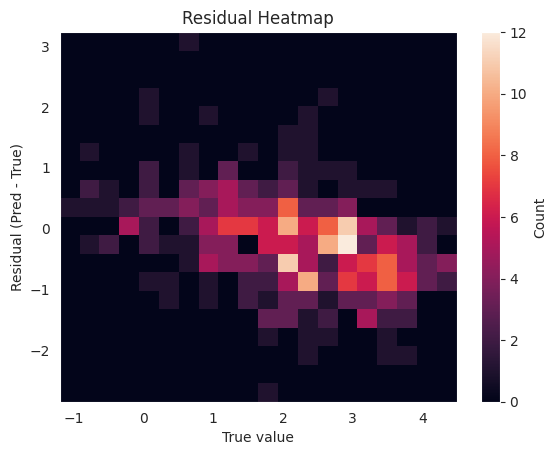

In [93]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

def test():
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())
    return y_true, y_pred

y_true, y_pred = test()
print(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")

def plot_residual_heatmap(y_true, y_pred, n_bins=20):
    residuals = y_pred - y_true

    plt.figure()
    plt.hist2d(y_true, residuals, bins=n_bins)
    plt.colorbar(label="Count")
    plt.xlabel("True value")
    plt.ylabel("Residual (Pred - True)")
    plt.title("Residual Heatmap")
    plt.show()

def plot_true_vs_pred(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.title("True vs Predicted Values")
    plt.show()

plot_true_vs_pred(np.array(y_true).flatten(), np.array(y_pred).flatten())
plot_residual_heatmap(np.array(y_true).flatten(), np.array(y_pred).flatten(), n_bins=20)



# Generar solución para el torneo

In [94]:
device = "cpu"

loader = DataLoader(dataset[dataset.test_idx], batch_size=len(dataset.test_idx))
model.eval()
model.to(device)

predictions = []
with torch.no_grad():
    for data in loader:
        data = data.to(device)
        out = model(data)
        for i, nid in enumerate(data.nid.cpu().tolist()):
            predictions.append({"nid": nid, "y": out[i].cpu().item()})


df_predictions = pd.DataFrame(predictions)

file_path = "test_predictions.json"
with open(file_path, 'w') as f:
    json.dump({'nid': df_predictions['nid'].tolist(), 'y': df_predictions['y'].tolist()}, f, indent=4)